# Analysis of model data

A quick exploratory analysis of datasets obtained from Victor D. 

## Import modules and define functions

In [1]:
%matplotlib inline
import scipy
from scipy import stats as st
import pynbody as pb
from datetime import datetime
from xml.etree.ElementInclude import include
from matplotlib.colors import LogNorm
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter as gf

model_dir = 'run732HF/'
#model_dir = 'SB_models/'
#model_dir = 'SB_nogas_models/'
base_dir = '/home/ubuntu/projects/S2B/models/' + model_dir
image_dir = '/home/ubuntu/projects/S2B/images/bar-shapes/' + model_dir

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def bar_align(galaxy, rbar, barfrac = 0.5, zlim=0.5, log=False):
    """
    Aligns the bar of pynbody galaxy simulation with the x-axis assuming the
    galaxy disc is already aligned to the XY plane using the inertial tensor.

    Function does not return any values/object. Pynbody functions effect the
    global variable which stores 'galaxy' so rotations within the functions
    are applied to input variable 'galaxy'.

    Parameters
    ----------
    galaxy : pynbody simulation object
        Galaxy object in the XY plane to be aligned.

    rbar : float
        Bar radius in simulation units e.g. kpc.

    barfrac : float
        Fraction of bar length to calculate the inertial tensor within in
        simulation units e.g. kpc.

    zlim : float
        Vertical limit to calculate intertial tensor within in simulation units
        e.g. kpc. Useful in galaxies with thick discs and weak bars.

    log : Bool
        Flag to output print statements.

    Returns
    -------
    None

    """
    if np.isnan(rbar):
        if log:
            print('* Bar undefined, using 1 kpc')
        rbar = 1.0
    elif rbar*barfrac < 1.:
        rbar = 1
        if log:
            print('* Short Bar, using 1 kpc')
    else:
        rbar = rbar*barfrac
        if log:
            print('* Bar defined, aligning to {} kpc'.format(rbar))

    if log:
        print('* Realigning bar using |z| < {} '.format(zlim))

    zfilt = pb.filt.LowPass('z',zlim)&pb.filt.HighPass('z',-zlim)
    rfilt = pb.filt.LowPass('rxy',rbar)

    x = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,0]
    y = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,1]
    m = np.array(galaxy.star[zfilt&rfilt]['mass'])

    #Calculate the inertia tensor
    I_yy, I_xx, I_xy = np.sum(m*y**2),np.sum(m*x**2),np.sum(m*x*y)
    I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])

    #Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(I)
    lowest = eigenvalues.argmin()
    maj_axis = eigenvectors[:, lowest]

    #Get the angle we need to rotate by
    r_angle = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))

    galaxy.rotate_z(-r_angle)

    if log:
        print('* Bar realigned by {} degrees'.format(r_angle))

    return None

def pbload(filename, paramname=None, log=False):
    if log:
        print('* Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    if log:
        print('* Centering the data...')
    pb.analysis.angmom.faceon(sim)
    bar_align(sim,3.,barfrac=1.,zlim=0.5,log=log)
    return sim

def load_data_lst():
    s_lst = []
    for snap in snap_lst:
        
        snap_name = snap.replace('.gz','')
        
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]))
        pb.analysis.angmom.faceon(s)
        bar_align(s,3.,barfrac=1.,zlim=0.5,log=True)
        s_lst.append(s)
    return(s_lst)

def list_snaps(base_dir):
    import os
    # list to store files
    snap_lst = []
    param_lst = []
    # Iterate directory
    for path in os.listdir(base_dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(base_dir, path)) and '.gz' in path:
            snap_lst.append(path)
        elif os.path.isfile(os.path.join(base_dir, path)) and '.param' in path:
            param_lst.append(path)
    return(sorted(snap_lst),sorted(param_lst))

snap_lst , param_lst = list_snaps(base_dir)
print(snap_lst)
print(param_lst)


['run732HF.01200.gz', 'run732HF.01210.gz', 'run732HF.01220.gz', 'run732HF.01230.gz', 'run732HF.01240.gz', 'run732HF.01250.gz', 'run732HF.01260.gz', 'run732HF.01270.gz', 'run732HF.01280.gz', 'run732HF.01290.gz', 'run732HF.01300.gz', 'run732HF.01310.gz', 'run732HF.01320.gz', 'run732HF.01330.gz', 'run732HF.01340.gz', 'run732HF.01350.gz', 'run732HF.01360.gz', 'run732HF.01370.gz', 'run732HF.01380.gz', 'run732HF.01390.gz']
['run732HF.param']


## Binned 2d-statistics for number density and velocity

### Number density

#### Face-on - inner bar development, model 732HF

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656133 degrees
Iterantion 0 ellipticity  0.038674763253807365
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01240.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 103.69997384566695 degrees
Iterantion 4 ellipticity  0.03571466614086882
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01280.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 179.4765536288629 degrees
Iterantion 8 ellipticity  0.003106948412622823
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01320.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0

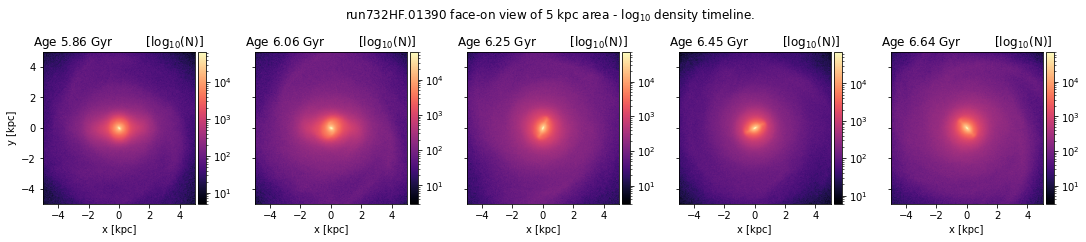

In [11]:
# Figure 6
#
# Zoom in
# Nuclear bar
#xlim, ylim = 1, 1 #kpc
# Primary bar
xlim, ylim = 5, 5 #kpc
bins = 200
cmap = 'magma'
plt_title = ' face-on view of ' + str(xlim) + ' kpc area' + ' - log$_{10}$ density timeline.'

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

# Model 732HF
panels = iter
# Model 708
#panels = 1

figsize_x = 3*panels
figsize_y = 3.5
# make the figure and sub plots
fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))

i = 0
j = 0

for snap in snap_lst:

    if j in iter_lst:
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        s = pbload(base_dir + snap,param_fname,log=True)
      
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                statistic = 'count',
                                range = [[-xlim,xlim],[-ylim,ylim]],
                                bins = bins)
        
        #print('Iterantion', j, 'bin counts',stat2d)
        #array = np.array(stat2d)
        #print('Iterantion', j, 'bin counts in NP array',array)

        #print('Iterantion', j, 'bin count summing in NP array.')
        s_xaxis = []
        s_yaxis = [0]*bins
        for e in stat2d:
            s_xaxis.append(sum(e))
            s_yaxis = s_yaxis + e
        #print('Sum along x-axis', s_xaxis)
        #print('Sum along y-axis', s_yaxis)

        #r_lst = [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
        r_lst = []
        unit = 2*xlim/bins

        for iter in range (0, int(bins/2)):
            r = xlim - unit*iter
            r_lst.append(r)
        #print(r_lst)

        for iter in range (0, int(bins/2)):
            r = unit + unit*iter
            r_lst.append(r)
        #print(r_lst)

        q_x = 0
        q_y = 0

        for iter in range (0, bins - 1):
            q_y = q_y + s_yaxis[iter]*(r_lst[iter]**2)
            q_x = q_x + s_xaxis[iter]*(r_lst[iter]**2)

        e = 1- sqrt(q_y / q_x)

        print('Iterantion', j, 'ellipticity ',e)

        image = axes[i].imshow(stat2d.T, 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
        xcent = (xedges[1:] + xedges[:-1]) / 2
        ycent = (yedges[1:] + yedges[:-1]) / 2
        #axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
        splt_title = 'Time ' + str(age) + ' Gyr' + '         [log$_{10}$(N)]'
        axes[i].title.set_text(splt_title)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(image, cax=cax, orientation='vertical')
        #cbar.set_label(cbar_label_lst[i])
        if i > 0:
            axes[i].set_yticklabels([])
        i += 1
        j += 1
    else: 
        j += 1

fig.tight_layout()
fig.suptitle(snap.replace(".gz","") + plt_title)
plt.setp(axes[:], xlabel = 'x [kpc]')
plt.setp(axes[0], ylabel = 'y [kpc]')
plt.savefig(image_dir + snap.replace(".gz","") + '_face_on_num_density_' + str(xlim) + 'kpc' + '.png')
print('* Done!')
plt.show()


#### Face-on - bar development, model 708

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656056 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 174.59931084286313 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 88.64641316008235 degrees


IndexError: index 2 is out of bounds for axis 0 with size 2

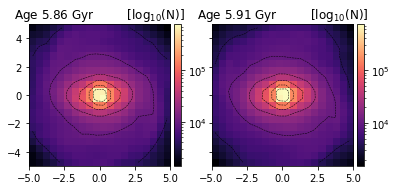

In [3]:
# Figure 6
#
# Zoom in
# Primary bar
xlim, ylim = 5, 5 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on view of ' + str(xlim) + ' kpc area' + ' - log$_{10}$ density timeline.'

# Model 708
panels = 2

figsize_x = 3*panels
figsize_y = 3.5
# make the figure and sub plots
fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))

i = 0
for snap in snap_lst:

        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        s = pbload(base_dir + snap,param_fname,log=True)
      
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                statistic = 'count',
                                range = [[-xlim,xlim],[-ylim,ylim]],
                                bins = bins)
    
        image = axes[i].imshow(stat2d.T, 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
        xcent = (xedges[1:] + xedges[:-1]) / 2
        ycent = (yedges[1:] + yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
        splt_title = 'Age ' + str(age) + ' Gyr' + '         [log$_{10}$(N)]'
        axes[i].title.set_text(splt_title)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(image, cax=cax, orientation='vertical')
        #cbar.set_label(cbar_label_lst[i])
        if i > 0:
            axes[i].set_yticklabels([])
        i += 1

fig.tight_layout()
fig.suptitle(snap.replace(".gz","") + plt_title)
plt.setp(axes[:], xlabel = 'x [kpc]')
plt.setp(axes[0], ylabel = 'y [kpc]')
plt.savefig(image_dir + snap.replace(".gz","") + '_face_on_num_density_' + str(xlim) + 'kpc' + '.png')
print('* Done!')
plt.show()


#### Face-on bar for different age groups

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01310.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 127.40061832790686 degrees
* Snap max age - 6.55Gyr.
** Total stars in snap -  9296457
*** Stars in age group 1  -  1641024
*** Stars in age group 2  -  2447906
*** Stars in age group 3  -  5207184
**** Done!


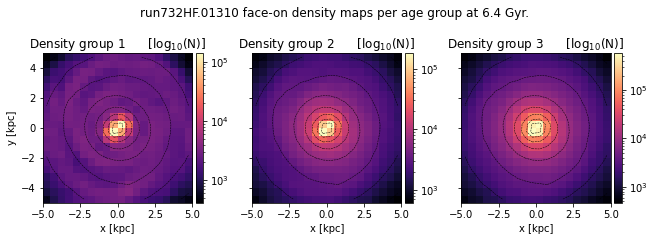

In [8]:
# Zoom in
#xlim, ylim = 1, 1 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 3, 3 #kpc
xlim, ylim = 5, 5 #kpc
#xlim, ylim = 10, 10 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on density maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

#snap_lst = ['run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
#            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
#            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

snap_lst = ['run732HF.01310.gz']

div_lst = [1/3]

#j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        stat2d_lst = []
         
        # Make the figure and sub plots
        #fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        fig,axes = plt.subplots(1,x_panels,figsize=(figsize_x,figsize_y))
    
        '''
        # Number density statistics face-on for inner bar reference plot
        df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
        stat2d_lst.append(df_stat2d.T)
        '''
                        
        # Divide snapshot into 3 age groups
        max_age = round(max(s.star['age']),2)
        print('* Snap max age - ' + str(max_age) + 'Gyr.')
        print('** Total stars in snap - ', len(s.star))
            
        # Number density statistics per age group
        divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
        age_grp = 0
        for divlr in divlr_lst:
            age_grp += 1
            div_l = divlr[0]
            div_r = divlr[1]
            # Mask stars between age dividers div_l and div_r
            mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
            # print(len(mask))
            s_grp = s.star[mask]
            print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
            
            # Number density statistics face-on for stellar population by age group
            dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(dfg_stat2d.T)
    
        for i in range(x_panels):
            image = axes[i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
            xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
            ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
            axes[i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            axes[i].title.set_text(splt_title_lst[i])
                    
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])

        fig.tight_layout()
        fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr.')
        plt.setp(axes[:], xlabel = 'x [kpc]')
        plt.setp(axes[0], ylabel = 'y [kpc]')
        plt.savefig(image_dir + snap.replace(".gz","") + '_density_by_age_3grp_' + str(xlim) + 'kpc' + '.png')
        print('**** Done!')
        plt.show()
            
    #j += 1

### Velocity distribution

#### Edge-on velocity distribution map series

In [ ]:
# Figure 7
#
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
plt_title = ' edge-on velocity distribution maps'

# Figure 7
splt_title_lst = ['Density                          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]']

'''
# Figure 13
splt_title_lst = ['Density                          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]',
                  'h$_{3}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]',
                  'h$_{3}$    [km/s]',]
'''

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

# Density + mean velocity + sigma panels
# or
# mean velocity + sigma panels + h3
panels = 3

# Density + mean velocity + sigma panels + h3
# panels = 4

figsize_x = 3*panels
figsize_y = 3.5

incl = 90
pa_lst = [0]
#pa_lst = [0,30,60,90]

#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

# Figure 14
#pa_lst = [90]
# snap_lst = ['run761AV.02000.gz','run761BP.02000.gz','run761CK.02400.gz','run761CL.02400.gz']

j = 0

for pa in pa_lst:
    for snap in snap_lst:
        
        if j in iter_lst:
            stat2d_lst = []
        
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
    
            # Load snapshot data, center face-on, align primary bar using inertia tensor
            snap_name = snap.replace('.gz','')
            param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
            #print(param_fname[0])
            s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
            #s = pbload(base_dir + snap,param_fname,log=True)
    
            # Snapshot age
            age = round(s.properties['time'].in_units('Gyr'),2)
    
            if pa != 0:
                s.rotate_z(-pa)
                print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(df_stat2d.T)
        
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) # Rotate to certain inclination
    
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
            # Mean velicity statistics
            vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vm_stat2d.T)
    
            # Velocity dispersion statistics
            vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vd_stat2d.T)
    
            # Gauss-Hermite h3 moment
            h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h3_stat2d.T)
    
            '''
            # Gauss-Hermite h4 moment
            h4_stat2d,h4_xedges,h4_yedges,h4_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 4),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h4_stat2d.T)
            '''
    
            for i in range(panels):
                if i == 0:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                    xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                    ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                else:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                    ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
    
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])
        
            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.setp(axes[1], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('* Done!')
            plt.show()
            j += 1
        else:
            j += 1


#### Sigma maps by age for different PA and inclinations with density reference maps

In [ ]:
# Zoom in
xlim, ylim = 1, 1 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 3, 3 #kpc
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 10, 10 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on density & edge-on velocity dispersion maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]',
                  'σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3

# Figure 8 - 10
y_panels = 2

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Apendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

# Figure 8
#pa_lst = [0]
#snap_lst = ['run732HF.01380.gz']

# Figure 9
#pa_lst = [0,0]
#snap_lst = ['run732HF.01340.gz', 'run732HF.01360.gz']

# Figure 10
#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

# Figure 12 - discarded, no X-shape, 
# but could be used as a negative control
# SB model 708
#pa_lst = [90]
#incl_lst = [85,88,89,90,91,92,95]

pa_lst = [-45,-60,-64,-90,-63,45,-80,-5,-85]
snap_lst = ['run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

div_lst = [1/3]

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        pa = pa_lst[j]
        if pa != 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
            
        for incl in incl_lst:
    
            stat2d_lst = []
            
            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
            '''
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(df_stat2d.T)
            '''
                        
            # Divide snapshot into 3 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr.')
            print('** Total stars in snap - ', len(s.star))
            
            # Number density statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            age_grp = 0
            for divlr in divlr_lst:
                age_grp += 1
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]
                print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
                
                # Number density statistics face-on for stellar population by age group
                dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(dfg_stat2d.T)
            
            # Rotate to a given inclination
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
        
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            # Velocity statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            for divlr in divlr_lst:
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]

                '''
                # Mean velicity statistics
                vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
                stat2d_lst.append(vm_stat2d.T)
                '''
    
                # Velocity deviation statistics
                vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'std',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(vd_stat2d.T)
    
                '''
                # Gauss-Hermite h3 moment
                h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
                stat2d_lst.append(h3_stat2d.T)
                '''
            for k in range(y_panels):
                for i in range(x_panels):
                    if k == 0:
                        image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                        xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                        ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                        axes[k,i].title.set_text(splt_title_lst[3*k+i])
                    else:
                        image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                        xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                        ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                        xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                        ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, stat2d_lst[3*k+i], linewidths = 1, linestyles = 'solid', colors = 'w')
                        axes[k,i].title.set_text(splt_title_lst[3*k+i])
                    
                    divider = make_axes_locatable(axes[k,i])
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                    #cbar.set_label(cbar_label_lst[i])
                    if i > 0:
                        axes[k,i].set_yticklabels([])

            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:,:], xlabel = 'x [kpc]')
            plt.setp(axes[0,0], ylabel = 'y [kpc]')
            plt.setp(axes[1,0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_by_age_3grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('**** Done!')
            plt.show()
            
        j += 1

#### Sigma maps by age for different PA and inclinations NO density reference maps

In [ ]:
# Zoom in
# model 732
xlim, ylim = 1, 1 #kpc
#
# model 708
#xlim, ylim = 5, 5 #kpc

bins = 20
cmap = 'magma'
plt_title = ' - velocity dispersion maps per age group'
splt_title_lst = ['σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3

# Figure 11
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Appendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

# Figure 11
# S2B model 732HF
incl_lst = [88,89,89.5,90,90.5,91,92]
pa_lst = [45]
snap_lst = ['run732HF.01360.gz']

# Figure 12 new
# S2B model 732HF
#incl_lst = [90]
#pa_lst = [40,41,42,43,44,45,46,47,48,49,50]
#pa_lst = [30,35,40,45,50,55,60]
#snap_lst = ['run732HF.01360.gz']

# Figure 12+
# SB model 708
#pa_lst = [0]
#incl_lst = [85,88,89,90,91,92,95]

div_lst = [1/3]

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        #pa = pa_lst[j]
            
        for incl in incl_lst:
            
            for pa in pa_lst:
                if pa != 0:
                    s.rotate_z(-pa)
                    print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
    
                stat2d_lst = []
            
                # Rotate to a given inclination
                print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
                s.rotate_x(-incl)
            
                # Make the figure and sub plots
                fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
                '''
                # Number density statistics face-on for inner bar reference plot
                df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                   statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(df_stat2d.T)
                '''
                        
                # Divide snapshot into 3 age groups
                max_age = round(max(s.star['age']),2)
                print('* Snap max age - ' + str(max_age) + 'Gyr.')
                print('** Total stars in snap - ', len(s.star))
                
                # Number density statistics for velocity maps density contours
                de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
                # Velocity statistics per age group
                divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
                for divlr in divlr_lst:
                    div_l = divlr[0]
                    div_r = divlr[1]
                    # Mask stars between age dividers div_l and div_r
                    mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                    # print(len(mask))
                    s_grp = s.star[mask]

                    '''
                    # Mean velicity statistics
                    vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'mean',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                    stat2d_lst.append(vm_stat2d.T)
                    '''

                    # Velocity deviation statistics
                    vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = 'std',
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(vd_stat2d.T)

                    '''
                    # Gauss-Hermite h3 moment
                    h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(h3_stat2d.T)
                    '''
                
                for i in range(x_panels):
                    gf_result = gf(stat2d_lst[i],sigma=0.25)
                    image = axes[i].imshow(gf_result, 
                                origin = 'lower',
                                extent = [-xlim, xlim, -ylim, ylim ],
                                cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                    ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, gf_result, linewidths = 1, linestyles = 'solid', colors = 'w')
                    axes[i].title.set_text(splt_title_lst[i])
                        
                    divider = make_axes_locatable(axes[i])
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                    #cbar.set_label(cbar_label_lst[i])
                    if i > 0:
                        axes[i].set_yticklabels([])

                print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
                s.rotate_x(incl) # Rotate back to original position

                if pa != 0:
                    s.rotate_z(pa)
                    print('* Rotating the primary bar back to original PA ' + str(pa) + ' deg.')

                fig.tight_layout()
                fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
                plt.setp(axes[:], xlabel = 'x [kpc]')
                plt.setp(axes[0], ylabel = 'z [kpc]')
                plt.savefig(image_dir + snap.replace(".gz","") + '_no_dens_LOSVD_by_age_3grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
                print('**** Done!')
                plt.show()

        j = j + 1


#### Sigma maps for ONE star age group for different PA and inclinations NO density reference maps

In [ ]:
from scipy.ndimage import gaussian_filter as gf
hist=plt.hist2d(sim['HR'].s['x'],sim['HR'].s['y'],bins=np.linspace(-30,30,100),norm=LN())
plt.contour(gf(hist[0],sigma=1),levels=np.logspace(1,5,50))

# Also try a background subtraction

In [ ]:
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
plt_title = ' - velocity dispersion maps age group 1'
splt_title_lst = ['σ$_{v}$ group 1  ','  [km/s]']
cbar_label_lst = ['σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 4

# Figure 11
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Apendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

# Figure 11
# S2B model 732HF
#incl_lst = [85,88,89,90,91,92,95]
#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

# Figure 12 new
# S2B model 732HF
incl_lst = [90]
#pa_lst = [40,41,42,43,44,45,46,47,48,49,50]
pa_base = 45
pa_delta = -30
pa_lst = [pa_base,pa_base + pa_delta,pa_base + 2*pa_delta,pa_base + 3*pa_delta]
snap_lst = ['run732HF.01360.gz']

div_lst = [1/3]

for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        # Max age and number of stars in snapshot
        max_age = round(max(s.star['age']),2)
        print('* Snap max age - ' + str(max_age) + 'Gyr.')
        print('** Total stars in snap - ', len(s.star))
       
        for incl in incl_lst:
                      
            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
            
            i = 0
            
            for pa in pa_lst:
                if pa != 0:
                    print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
                    s.rotate_z(-pa)
    
                stat2d_lst = []
            
                # Rotate to a given inclination
                print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
                s.rotate_x(-incl)
            
                # Number density statistics for velocity maps density contours
                de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
                # Velocity statistics per age group 1
                divlr_lst = [[0,div]]
                for divlr in divlr_lst:
                    div_l = divlr[0]
                    div_r = divlr[1]
                    # Mask stars between age dividers div_l and div_r
                    mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                    # print(len(mask))
                    s_grp = s.star[mask]

                    '''
                    # Mean velicity statistics
                    vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'mean',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                    stat2d_lst.append(vm_stat2d.T)
                    '''

                    # Velocity deviation statistics
                    vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = 'std',
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(vd_stat2d.T)

                    '''
                    # Gauss-Hermite h3 moment
                    h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(h3_stat2d.T)
                    '''
                
                gf_result = gf(stat2d_lst[0],sigma=0.25)
                image = axes[i].imshow(gf_result, 
                                origin = 'lower',
                                extent = [-xlim, xlim, -ylim, ylim ],
                                cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, gf_result, linewidths = 1, linestyles = 'solid', colors = 'w')
                #axes[i].title.set_text(splt_title_lst[0])
                
                PA_nb = 90 + i*pa_delta
                print('Panel:', i, '\tPA: ', pa, '\tPA_nb:', PA_nb)
                
                axes[i].title.set_text(splt_title_lst[0] + 'PA$_{NB}$ ' + str(PA_nb) + ' deg ' + splt_title_lst[1])
                        
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])

                print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
                s.rotate_x(incl) # Rotate back to original position

                if pa != 0:
                    s.rotate_z(pa)
                    print('* Rotating the primary bar back to original PA ' + str(-pa) + ' deg.')

                i+=1
                
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr,' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_no_dens_LOSVD_by_age_1grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('**** Done!')
            plt.show()


#### Edge-on velocity components, NO density

In [ ]:
# Figure 14
#
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
#plt_title = '732HF face-on number density & edge-on velocity and h3 maps per age group'
plt_title = ' mean velocity, velocity dispersion and h3 maps for age group 1'
splt_title_lst = ['v$_{mean}$ group 1     [km/s]',
                  'σ$_{v}$ group 1        [km/s]',
                  'h$_{3}$ group 1        [km/s]']
cbar_label_lst = ['[km/s]',
                  '[km/s]',
                  '[km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

panels = 3
figsize_x = 3*panels
figsize_y = 3.5

incl_lst = [90]
#incl_lst = [85,88,89,90,91,92,95]

# pa_lst = [0]
# for Appendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

#pa_lst = [-5,-85]
#snap_lst = ['run732HF.01380.gz', 'run732HF.01390.gz']

# Figure 14
#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

pa_lst = [65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]
snap_lst = ['run732HF.01290.gz','run732HF.01300.gz',
            'run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

#pa_lst = [90]
#snap_lst = ['run708mainDiffCR.01200.gz']

div_lst = [1/3]

# for pa in pa_lst:
for div in div_lst:
    j = 0
    for snap in snap_lst:
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,param_fname,log=True)
        
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        pa = pa_lst[j]
        if pa != 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
        for incl in incl_lst:
    
            stat2d_lst = []
            
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
        
            # Divide snapshot into 2 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr')
            print('** Total stars in snap - ', len(s.star))
                       
            # Rotate to a given inclination
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
        
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            # Velocity statistics per age group
            divlr_lst = [[0,div]]
            for divlr in divlr_lst:
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask group 1 stars
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]

                # Mean velicity statistics
                vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
                stat2d_lst.append(vm_stat2d.T)
    
                # Velocity deviation statistics
                vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'std',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(vd_stat2d.T)
    
                # Gauss-Hermite h3 moment
                h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
                stat2d_lst.append(h3_stat2d.T)

            for i in range(panels):
                image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
            
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])
        
            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_h3_by_age_1grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('* Done!')
            plt.show()
            
        j += 1
            

#### Edge-on velocity distribution map series

In [ ]:
# Figure 13
#
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 1, 1 #kpc
#xylim_lst = [1,2,5] #kpc
xylim_lst = [15] #kpc
bins = 20
cmap = 'magma'
plt_title = ' edge-on velocity distribution maps'
splt_title_lst = ['Number density          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]',
                  'h$_{3}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]',
                  'h$_{3}$    [km/s]',]

panels = 4
figsize_x = 3*panels
figsize_y = 3.5

incl = 90
pa_lst = [90]

for snap in snap_lst:
    for xylim in xylim_lst:
        # Define zoom-in area
        xlim = xylim
        ylim = xylim
        for pa in pa_lst:
    
            stat2d_lst = []
        
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
    
            # Load snapshot data, center face-on, align primary bar using inertia tensor
            snap_name = snap.replace('.gz','')
            param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
            #print(param_fname[0])
            s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
            #s = pbload(base_dir + snap,param_fname,log=True)
    
            # Snapshot age
            age = round(s.properties['time'].in_units('Gyr'),2)
    
            if pa > 0:
                s.rotate_z(-pa)
                print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(df_stat2d.T)
        
            # Tilt to inclinantion
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
    
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
            # Mean velicity statistics
            v_stat2d,v_xedges,v_yedges,v_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(v_stat2d.T)
    
            # Velocity dispersion statistics
            vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vd_stat2d.T)
    
            # Gauss-Hermite h3 moment
            h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h3_stat2d.T)
    
            # Gauss-Hermite h4 moment
            h4_stat2d,h4_xedges,h4_yedges,h4_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 4),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h4_stat2d.T)
    
            for i in range(panels):
                if i == 0:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                    xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                    ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                else:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (v_xedges[1:] + v_xedges[:-1]) / 2
                    ycent = (v_yedges[1:] + v_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
        
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])

            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Tilt back to face-on
            
            if pa > 0:
                print('* Rotating the primary bar back PA = 0')
                s.rotate_z(pa)
            
            fig.tight_layout()
            #fig.suptitle(snap_lst[j].replace(".gz",": ") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
            fig.suptitle(snap.replace(".gz",": ") + plt_title + ' R=' + str(xlim) + ' kpc' + ' at ' + 'PA ' + str(pa) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.setp(axes[1], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_h3_h4_' + str(xlim) + 'kpc' + '_pa' + str(pa) + '.png')
            print('* Done!')
            plt.show()
    